In [1]:
# !pip install path.py;
# !pip install open3d
#!pip install chamferdist

In [1]:
%matplotlib inline
import numpy as np
#from chamferdist import ChamferDistance
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from path import Path
#import plyfile as ply
from plyfile import PlyData, PlyElement

import sys
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

import shutil
import urllib
import urllib.request
import tarfile

import random
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px
import copy

from scipy.spatial import ConvexHull, convex_hull_plot_2d


In [2]:
from pytorch3d.loss.chamfer import chamfer_distance

In [3]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
def read_pt(filepath):
    #print(filepath)
    full_pointcloud = torch.load(filepath)
    full_pointcloud= full_pointcloud.T
    return full_pointcloud

In [5]:
def get_ransac_planes(xyz):
  #xyz is a numpy array of shape (x,3) containing all points of the pointcloud
  #returns the most prominent horizontal plane
  obj= xyz.copy()
  objct = o3d.geometry.PointCloud()
  objct.points = o3d.utility.Vector3dVector(obj)

#   xyz[:,2]= xyz[:,2]-1

#   pcd = o3d.geometry.PointCloud()
#   pcd.points = o3d.utility.Vector3dVector(xyz)

#   diameter = np.linalg.norm(
#       np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
#   camera = [0, 0, diameter]
#   radius = diameter * 100

#   _, pt_map = pcd.hidden_point_removal(camera, radius)

#   pcd = pcd.select_by_index(pt_map)
#   xyz= np.asarray(pcd.points)

#   xyz[:,2]= xyz[:,2]+1

  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(xyz)

  while(1):
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.05,
                                            ransac_n=3,
                                            num_iterations=1000)
    [a, b, c, d] = plane_model
    if abs(a)<0.5 and abs(b)<0.5:
      plane= pcd.select_by_index(inliers)
      outliers= objct.select_by_index(inliers, invert=True)
      xyz= np.asarray(plane.points)
      break
    else:
      pcd= pcd.select_by_index(inliers, invert= True)
      if len(list(np.asarray((pcd.points))))<3:
        print('fail')
        return (None,None, None, None, None, None)
  return (xyz, obj, [a, b, c, d])


In [6]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig
    
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [7]:
def visualize_results(obj, xyz, a,b,c,d):
  points= xyz[:,:2]
  hull = ConvexHull(points)
  # plt.plot(points[:,0], points[:,1], 'o')
  # for simplex in hull.simplices:
  #     plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

  xss= obj[:,0]
  yss= obj[:,1]
  zss= obj[:,2]
  xs= xyz[:,0]
  ys= xyz[:,1]
  zs= xyz[:,2]

  fig = plt.figure(figsize=(8,4))
  ax = fig.add_subplot(121, projection='3d')
  #ax.scatter(xss, yss, zss, c='r')
  ax.scatter(xs, ys, zs)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  ax.set_zlim(-0.5,0.5)
  ax.set_xlim(-0.5,0.5)
  ax.set_ylim(-0.5,0.5)

  #fig = plt.figure()
  ax2 = fig.add_subplot(122, projection='3d')
  ax2.scatter(xss, yss, zss)

  ax2.set_xlabel('X Label')
  ax2.set_ylabel('Y Label')
  ax2.set_zlabel('Z Label')
  ax2.set_zlim(-0.5,0.5)
  ax2.set_xlim(-0.5,0.5)
  ax2.set_ylim(-0.5,0.5)

  plt.show()

  print('Equation of plane ', a,b,c,d)
  print('Area of horizaontal surface ', hull.area)

def visualize_single_pc(xyz):
  xss= obj[:,0]
  yss= obj[:,1]
  zss= obj[:,2]
  xs= xyz[:,0]
  ys= xyz[:,1]
  zs= xyz[:,2]

  fig = plt.figure(figsize=(4,4))
  ax = fig.add_subplot(111, projection='3d')
  #ax.scatter(xss, yss, zss, c='r')
  ax.scatter(xs, ys, zs)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  ax.set_zlim(-0.5,0.5)
  ax.set_xlim(-0.5,0.5)
  ax.set_ylim(-0.5,0.5)

  plt.show()


In [8]:
pointcloud= read_pt('/home/ubuntu/3d-point-clouds-HyperCloud/3d_point_cloud/dataset/shapenet_training_no_noise/bathtub/bathtub_090/bathtub_090.pt')

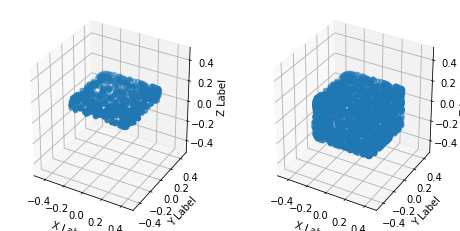

Equation of plane  -0.008107519624346169 -0.0024139954929229615 0.9999642197355367 -0.14875554724956636
Area of horizaontal surface  2.3423663162430906


In [9]:
xyz, obj, [a, b, c, d]= get_ransac_planes(pointcloud.T)
if a!= None:
    visualize_results(obj, xyz, a,b,c,d)

In [10]:
def getDirNum(num):
    l= len(str(num))
    return '0'*(3-l) +str(num)

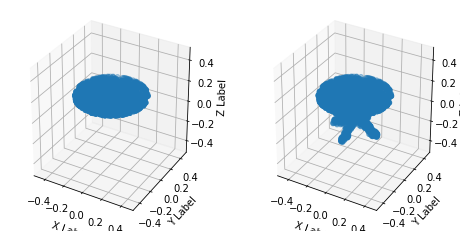

Equation of plane  -0.001036692001244979 -0.002884939796944829 0.9999953011849918 -0.1593781139004603
Area of horizaontal surface  2.0744035018035194


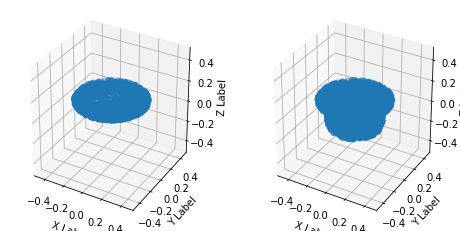

Equation of plane  -0.005509069644618456 0.006672284533041115 0.9999625646846789 -0.11837783215583474
Area of horizaontal surface  2.1379633341886395


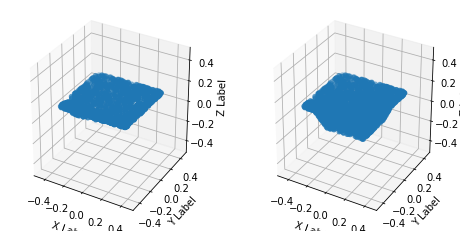

Equation of plane  -0.0245938711019322 0.0003399328657538098 0.9996974672118902 -0.11462986145205822
Area of horizaontal surface  2.6715974266186544


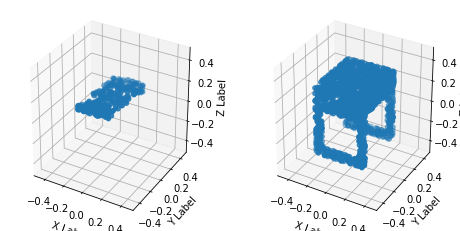

Equation of plane  -0.027163381846962313 0.016956124173602514 0.9994871887821503 -0.14448274953630966
Area of horizaontal surface  1.8266198915563743


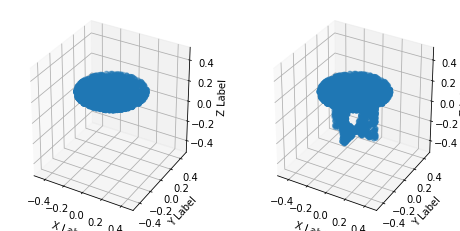

Equation of plane  0.0037118068420308485 -0.0009876802892149945 0.9999926234616002 -0.19740595391948726
Area of horizaontal surface  2.022239702838892


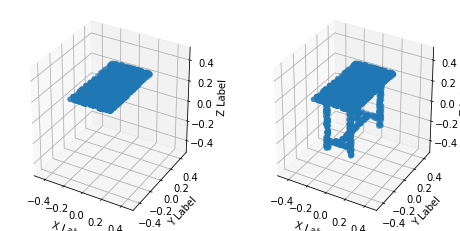

Equation of plane  -0.006987299299529727 -0.0016354316895676028 0.9999742511743428 -0.2485926856035164
Area of horizaontal surface  2.2921305017257807


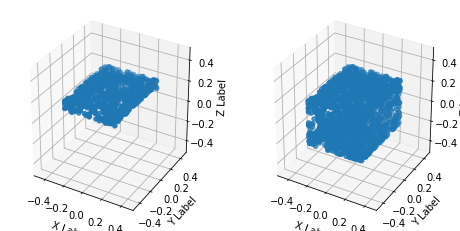

Equation of plane  -0.001182591084742639 -0.002118010730895552 0.9999970577501066 -0.18664587176406094
Area of horizaontal surface  2.5198178527793242


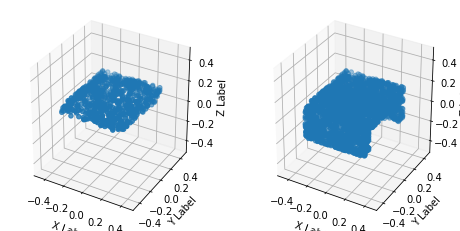

Equation of plane  0.0019211022761646181 0.025471364563056355 0.9996737062428621 -0.13752965987438795
Area of horizaontal surface  2.6728487980588236


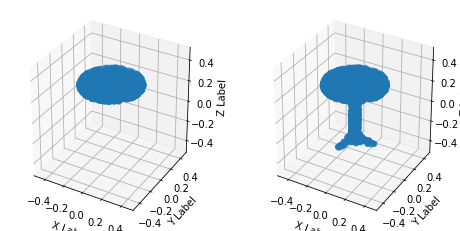

Equation of plane  0.00016241620466670925 0.0009319896084033936 0.999999552508073 -0.26954949310144444
Area of horizaontal surface  1.8379842155971442


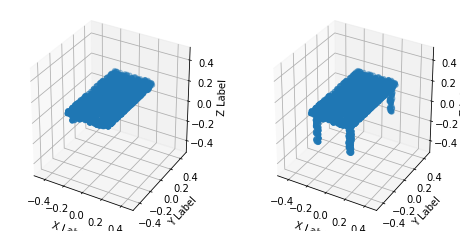

Equation of plane  -0.008543768731982369 0.0012516315797630585 0.9999627180221485 -0.13248587934291706
Area of horizaontal surface  2.5289350409681286


In [11]:
classes=['bathtub',  'bed',  'bench',  'bookshelf',  'cabinet',  'chair',  'lamp',  'monitor',  'sofa',  'table']

folder_path=  '/home/ubuntu/3d-point-clouds-HyperCloud/3d_point_cloud/dataset/shapenet_training_no_noise/'
cls_num= 9
subclass= 90
for subclass in range(10):
    filepath= folder_path+classes[cls_num]+'/'+classes[cls_num]+'_'+getDirNum(subclass)+'/'+classes[cls_num]+'_'+getDirNum(subclass)+'.pt'
    pointcloud= read_pt(filepath)
    try:
        xyz, obj, [a, b, c, d]= get_ransac_planes(pointcloud.T)
        
        if a!= None:
            visualize_results(obj, xyz, a,b,c,d)
    except:
        pass


In [12]:
def numPointDifference(planePoints1, planePoints2):
  return(abs(len(planePoints1)- len(planePoints2))/2025)

def chamferDistance(planePoints1, planePoints2):
  a= torch.FloatTensor([np.asarray(planePoints1)])
  b= torch.FloatTensor([np.asarray(planePoints2)])
  return(float(chamferDist(a,b, bidirectional=True)))
  
def distOrigin(eq1,eq2):
  a1,b1,c1,d1= eq1
  a2,b2,c2,d2= eq2
  return(abs(abs(d1)/np.sqrt(a1*a1+b1*b1+c1*c1)-  abs(d2)/np.sqrt(a2*a2+b2*b2+c2*c2)))

def calcAngle(eq1,eq2):
  a1,b1,c1,d1= eq1
  a2,b2,c2,d2= eq2
  return(np.arccos(abs(a1*a2+b1*b2+c1*c2)/(np.sqrt(a1*a1+b1*b1+c1*c1)*np.sqrt(a2*a2+b2*b2+c2*c2))))

def areaDiff(planePoints1, planePoints2):
  points1= np.asarray(planePoints1)[:,:2]
  points2= np.asarray(planePoints2)[:,:2]
  return ConvexHull(points1).area- ConvexHull(points2).area

In [12]:
testfile_path='/home/ubuntu/3d-point-clouds-HyperCloud/experiments_arpit/all_intra_class_multiple_epoch_dataset100/chair/chair_099/coordinates/chair_099_300_2_recon_coord.pt'

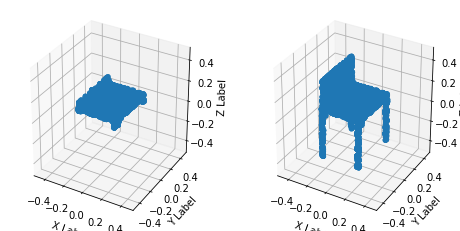

Equation of plane  0.06472136086418233 -0.0009963983177455934 0.9979028773574514 -0.1043806472574759
Area of horizaontal surface  1.8402882977110626


In [13]:
pointcloud= read_pt(testfile_path)
#try:
xyz, obj, [a, b, c, d]= get_ransac_planes(pointcloud)

if a!= None:
    visualize_results(obj, xyz, a,b,c,d)
# except:
#     pass


In [14]:
def load_test_data(path,c, category, epoch, example):
    if len(str(epoch))>4:
      n= str(epoch)
    else:
      n= '0'*(3-len(str(epoch)))+str(epoch)
    y= '0'*(3-len(str(category)))+str(category)
    #path+ bathtub/bathtub_000/coordinates/bathtub_000_300_2_recon_coord.pt
    coordinates = torch.load(path+c+'/'+c+'_'+y+'/coordinates/'+c+'_'+y+'_'+n+'_'+str(example)+'_'+'recon_coord.pt')
    coordinates= coordinates.T
    coordinates= Normalize()(coordinates)
    sampled_coordinates= np.asarray([coordinates[np.random.choice(len(coordinates), size=1024, replace=False)]])
    labels= torch.from_numpy(np.asarray([int(category)]))
    return sampled_coordinates, labels


def load_orig_data(c, category):
#     if len(str(epoch))>4:
#       n= str(epoch)
#     else:
#       n= '0'*(3-len(str(epoch)))+str(epoch)
#     y= '0'*(3-len(str(category)))+str(category)
    
    folder_path=  '/home/ubuntu/3d-point-clouds-HyperCloud/3d_point_cloud/dataset/shapenet_training_no_noise/'

    filepath= folder_path+c+'/'+c+'_'+getDirNum(category)+'/'+c+'_'+getDirNum(category)+'.pt'
    pointcloud= read_pt(filepath).T
    coordinates= Normalize()(pointcloud)
    sampled_coordinates= np.asarray([coordinates[np.random.choice(len(coordinates), size=1024, replace=False)]])
    labels= torch.from_numpy(np.asarray([int(category)]))
    
    return sampled_coordinates, labels

# Saving example results

In [17]:
classes=['chair',  'table']
classcount=0
results=np.zeros((2,4,151,2))
results=[]
for i in range(2):
    b=[]
    for j in range(4):
        a=[]
        for k in range(151):
            a.append([[],[]])
        b.append(a)
    results.append(b)
    
for c in classes:
    path= '/home/ubuntu/3d-point-clouds-HyperCloud/experiments_arpit/all_intra_class_multiple_epoch_dataset100/'
    print (c)
    for category in range(4): 
        print('Class '+str(category))
        epochs=[]
        count=0
        reference, reflabels = load_orig_data(c, category)
        results[classcount][category][0][0]= reference[0]
        try:
            planePoints1, objpoints1, eq1= get_ransac_planes(reference[0])
            results[classcount][category][0][1]= planePoints1
            for epoch in range(2,302,2): 
                if epoch%100==0:
                    print(epoch,' ',)
                for example in range(1):
                    inputs, labels = load_test_data(path,c, category, epoch,example)
                    results[classcount][category][count+1][0]= inputs[0]
                    try:
                        planePoints2, objpoints2, eq2= get_ransac_planes(inputs[0])
                        results[classcount][category][count+1][1]= planePoints2
                    except:
                        pass

                count+=1
                #break
        except:
            pass
    classcount+=1
                
    #np.save('/home/ubuntu/Pointnet/results/July03/ransac/'+c+'.npy', results)

chair
Class 0
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 1
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 2
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 3
fail
fail
fail
100  
200  
300  
table
Class 0
fail
fail
fail
fail
100  
200  
300  
Class 1
fail
fail
fail
fail
100  
200  
300  
Class 2
fail
fail
fail
100  
200  
300  
Class 3
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  


In [18]:
import pickle

with open('planes.pkl', 'wb') as f:
    pickle.dump(results, f)

In [19]:
with open('planes.pkl', 'rb') as f:
    mynewlist = pickle.load(f)

In [26]:
len(mynewlist[0][0])
mynewlist[0][0][0]

[array([[-2.7416989e-01,  3.1909263e-01,  2.6441306e-01],
        [-3.9377287e-01,  2.1761782e-01,  5.0353348e-01],
        [ 1.9693871e-01,  5.5815227e-02, -1.7899835e-01],
        ...,
        [ 3.7675509e-01,  3.8671974e-04, -9.8123349e-02],
        [ 3.7230320e-02,  2.5259423e-01, -1.0297497e-01],
        [-3.3757573e-01,  1.4708970e-01,  2.0347007e-01]], dtype=float32),
 array([[ 4.58050340e-01,  9.97066051e-02, -1.72416016e-01],
        [-2.52305686e-01,  3.64362150e-01,  9.92648974e-02],
        [ 3.87833625e-01,  1.34531602e-01, -9.33991075e-02],
        ...,
        [ 1.83134109e-01,  2.45485306e-01, -4.85645346e-02],
        [ 3.14491123e-01, -3.51175457e-01, -1.11729465e-01],
        [ 3.76755089e-01,  3.86719737e-04, -9.81233492e-02]])]

In [17]:
classes=['bed',  'bench',  'bookshelf',  'cabinet',  'chair',  'lamp',  'monitor',  'sofa',  'table']
for c in classes:
    path= '/home/ubuntu/3d-point-clouds-HyperCloud/experiments_arpit/all_intra_class_multiple_epoch_dataset100/'
    print (c)
    results=np.zeros((100,150,5))
    for category in range(100): 
        print('Class '+str(category))
        epochs=[]
        count=0
        reference, reflabels = load_orig_data(c, category)
        try:
            planePoints1, objpoints1, eq1= get_ransac_planes(reference[0])
            #print(eq1)
            for epoch in range(2,302,2): #### 1350 pcs available
                if epoch%100==0:
                    print(epoch,' ',)

                for example in range(1):
                    inputs, labels = load_test_data(path,c, category, epoch,example)
                    #print(inputs.shape)
                    try:
                        planePoints2, objpoints2, eq2= get_ransac_planes(inputs[0])
                        #print(eq2)
                        r1,r2,r3,r4,r5= (numPointDifference(planePoints1, planePoints2),
                        float(chamfer_distance(torch.from_numpy(np.asarray([planePoints1])).float(), torch.from_numpy(np.asarray([planePoints2])).float())[0].numpy()),
                        distOrigin(eq1,eq2),
                        calcAngle(eq1,eq2),
                        areaDiff(planePoints1, planePoints2))
                        #print(r1,r2,r3,r4,r5)
                        results[category][count][0]=r1
                        results[category][count][1]=r2
                        results[category][count][2]=r3
                        results[category][count][3]=r4
                        results[category][count][4]=r5
                    except:
                        pass

                count+=1
                #break
        except:
            pass
        #break
    #break
                
    np.save('/home/ubuntu/Pointnet/results/July03/ransac/'+c+'.npy', results)

bed
Class 0
fail
Class 1
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 2
fail
fail
fail
fail
fail
100  
200  
300  
Class 3
fail
fail
fail
fail
100  
200  
300  
Class 4
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 5
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 6
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 7
fail
fail
fail
fail
fail
100  
200  
fail
300  
Class 8
fail
fail
fail
fail
100  
200  
300  
Class 9
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 10
fail
fail
fail
100  
200  
300  
Class 11
fail
fail
fail
fail
fail
100  
200  
300  
Class 12
fail
fail
fail
fail
100  
200  
300  
Class 13
fail
fail
fail
fail
fail
100  
200  
300  
Class 14
fail
Class 15
fail
fail
fail
fail
100  
200  
300  
Class 16
fail
fail
fail
fail
fail
100  
200  
300  
Class 17
fail
fail
fail
fail
fail
fail
fail
100  
200  
fail
fail
300  
Class 18
fail
fail
fail
100  
200  
300  
Class 19
fail
Class 20
fail
fail
fail
fail
fail
f

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning:

invalid value encountered in double_scalars

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning:

invalid value encountered in double_scalars



fail
fail
fail
fail
100  
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
200  
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
300  
fail
Class 30
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 31
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 32
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 33
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 34
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
fail
fail
200  
fail
fail
fail
fail
fail
fail
300  
Class 35
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 36
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 37
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 38
fail
fail
fail
fail
fail
fail
fail
fail
100  
200  
300  
Class 39
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


In [16]:
np.save('/home/ubuntu/Pointnet/results/July03/ransac/'+c+'.npy', results)

In [47]:
r1,r2,r3,r4,r5= ( numPointDifference(planePoints1, planePoints2),
float(chamfer_distance(torch.from_numpy(np.asarray([planePoints1])).float(), torch.from_numpy(np.asarray([planePoints2])).float())[0].numpy()),
distOrigin(eq1,eq2),
calcAngle(eq1,eq2),
areaDiff(planePoints1, planePoints2))

In [45]:
float(chamfer_distance(torch.from_numpy(np.asarray([planePoints1])).float(), torch.from_numpy(np.asarray([planePoints2])).float())[0].numpy())

0.023204119876027107

In [32]:
torch.from_numpy(np.asarray([planePoints1])).shape

torch.Size([1, 137, 3])

In [34]:
objct = o3d.geometry.PointCloud()
objct.points = o3d.utility.Vector3dVector(planePoints1)

In [35]:
chamfer_distance(objct,objct)

ValueError: The input pointclouds should be either Pointclouds objects or torch.Tensor of shape (minibatch, num_points, 3).

In [38]:
type(torch.from_numpy(np.asarray([planePoints1])))

torch.Tensor

In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

from typing import Union

import torch
import torch.nn.functional as F
from pytorch3d.ops.knn import knn_gather, knn_points
from pytorch3d.structures.pointclouds import Pointclouds


def _validate_chamfer_reduction_inputs(
    batch_reduction: Union[str, None], point_reduction: str
):
    """Check the requested reductions are valid.

    Args:
        batch_reduction: Reduction operation to apply for the loss across the
            batch, can be one of ["mean", "sum"] or None.
        point_reduction: Reduction operation to apply for the loss across the
            points, can be one of ["mean", "sum"].
    """
    if batch_reduction is not None and batch_reduction not in ["mean", "sum"]:
        raise ValueError('batch_reduction must be one of ["mean", "sum"] or None')
    if point_reduction not in ["mean", "sum"]:
        raise ValueError('point_reduction must be one of ["mean", "sum"]')


def _handle_pointcloud_input(
    points: Union[torch.Tensor, Pointclouds],
    lengths: Union[torch.Tensor, None],
    normals: Union[torch.Tensor, None],
):
    """
    If points is an instance of Pointclouds, retrieve the padded points tensor
    along with the number of points per batch and the padded normals.
    Otherwise, return the input points (and normals) with the number of points per cloud
    set to the size of the second dimension of `points`.
    """
    if isinstance(points, Pointclouds):
        X = points.points_padded()
        lengths = points.num_points_per_cloud()
        normals = points.normals_padded()  # either a tensor or None
    elif torch.is_tensor(points):
        if points.ndim != 3:
            raise ValueError("Expected points to be of shape (N, P, D)")
        X = points
        if lengths is not None and (
            lengths.ndim != 1 or lengths.shape[0] != X.shape[0]
        ):
            raise ValueError("Expected lengths to be of shape (N,)")
        if lengths is None:
            lengths = torch.full(
                (X.shape[0],), X.shape[1], dtype=torch.int64, device=points.device
            )
        if normals is not None and normals.ndim != 3:
            raise ValueError("Expected normals to be of shape (N, P, 3")
    else:
        raise ValueError(
            "The input pointclouds should be either "
            + "Pointclouds objects or torch.Tensor of shape "
            + "(minibatch, num_points, 3)."
        )
    return X, lengths, normals


def chamfer_distance(
    x,
    y,
    x_lengths=None,
    y_lengths=None,
    x_normals=None,
    y_normals=None,
    weights=None,
    batch_reduction: Union[str, None] = "mean",
    point_reduction: str = "mean",
):
    """
    Chamfer distance between two pointclouds x and y.

    Args:
        x: FloatTensor of shape (N, P1, D) or a Pointclouds object representing
            a batch of point clouds with at most P1 points in each batch element,
            batch size N and feature dimension D.
        y: FloatTensor of shape (N, P2, D) or a Pointclouds object representing
            a batch of point clouds with at most P2 points in each batch element,
            batch size N and feature dimension D.
        x_lengths: Optional LongTensor of shape (N,) giving the number of points in each
            cloud in x.
        y_lengths: Optional LongTensor of shape (N,) giving the number of points in each
            cloud in x.
        x_normals: Optional FloatTensor of shape (N, P1, D).
        y_normals: Optional FloatTensor of shape (N, P2, D).
        weights: Optional FloatTensor of shape (N,) giving weights for
            batch elements for reduction operation.
        batch_reduction: Reduction operation to apply for the loss across the
            batch, can be one of ["mean", "sum"] or None.
        point_reduction: Reduction operation to apply for the loss across the
            points, can be one of ["mean", "sum"].

    Returns:
        2-element tuple containing

        - **loss**: Tensor giving the reduced distance between the pointclouds
          in x and the pointclouds in y.
        - **loss_normals**: Tensor giving the reduced cosine distance of normals
          between pointclouds in x and pointclouds in y. Returns None if
          x_normals and y_normals are None.
    """
    _validate_chamfer_reduction_inputs(batch_reduction, point_reduction)

    x, x_lengths, x_normals = _handle_pointcloud_input(x, x_lengths, x_normals)
    y, y_lengths, y_normals = _handle_pointcloud_input(y, y_lengths, y_normals)

    return_normals = x_normals is not None and y_normals is not None

    N, P1, D = x.shape
    P2 = y.shape[1]

    # Check if inputs are heterogeneous and create a lengths mask.
    is_x_heterogeneous = (x_lengths != P1).any()
    is_y_heterogeneous = (y_lengths != P2).any()
    x_mask = (
        torch.arange(P1, device=x.device)[None] >= x_lengths[:, None]
    )  # shape [N, P1]
    y_mask = (
        torch.arange(P2, device=y.device)[None] >= y_lengths[:, None]
    )  # shape [N, P2]

    if y.shape[0] != N or y.shape[2] != D:
        raise ValueError("y does not have the correct shape.")
    if weights is not None:
        if weights.size(0) != N:
            raise ValueError("weights must be of shape (N,).")
        if not (weights >= 0).all():
            raise ValueError("weights cannot be negative.")
        if weights.sum() == 0.0:
            weights = weights.view(N, 1)
            if batch_reduction in ["mean", "sum"]:
                return (
                    (x.sum((1, 2)) * weights).sum() * 0.0,
                    (x.sum((1, 2)) * weights).sum() * 0.0,
                )
            return ((x.sum((1, 2)) * weights) * 0.0, (x.sum((1, 2)) * weights) * 0.0)

    cham_norm_x = x.new_zeros(())
    cham_norm_y = x.new_zeros(())

    x_nn = knn_points(x, y, lengths1=x_lengths, lengths2=y_lengths, K=1)
    y_nn = knn_points(y, x, lengths1=y_lengths, lengths2=x_lengths, K=1)

    cham_x = x_nn.dists[..., 0]  # (N, P1)
    cham_y = y_nn.dists[..., 0]  # (N, P2)

    if is_x_heterogeneous:
        cham_x[x_mask] = 0.0
    if is_y_heterogeneous:
        cham_y[y_mask] = 0.0

    if weights is not None:
        cham_x *= weights.view(N, 1)
        cham_y *= weights.view(N, 1)

    if return_normals:
        # Gather the normals using the indices and keep only value for k=0
        x_normals_near = knn_gather(y_normals, x_nn.idx, y_lengths)[..., 0, :]
        y_normals_near = knn_gather(x_normals, y_nn.idx, x_lengths)[..., 0, :]

        cham_norm_x = 1 - torch.abs(
            F.cosine_similarity(x_normals, x_normals_near, dim=2, eps=1e-6)
        )
        cham_norm_y = 1 - torch.abs(
            F.cosine_similarity(y_normals, y_normals_near, dim=2, eps=1e-6)
        )

        if is_x_heterogeneous:
            cham_norm_x[x_mask] = 0.0
        if is_y_heterogeneous:
            cham_norm_y[y_mask] = 0.0

        if weights is not None:
            cham_norm_x *= weights.view(N, 1)
            cham_norm_y *= weights.view(N, 1)

    # Apply point reduction
    cham_x = cham_x.sum(1)  # (N,)
    cham_y = cham_y.sum(1)  # (N,)
    if return_normals:
        cham_norm_x = cham_norm_x.sum(1)  # (N,)
        cham_norm_y = cham_norm_y.sum(1)  # (N,)
    if point_reduction == "mean":
        cham_x /= x_lengths
        cham_y /= y_lengths
        if return_normals:
            cham_norm_x /= x_lengths
            cham_norm_y /= y_lengths

    if batch_reduction is not None:
        # batch_reduction == "sum"
        cham_x = cham_x.sum()
        cham_y = cham_y.sum()
        if return_normals:
            cham_norm_x = cham_norm_x.sum()
            cham_norm_y = cham_norm_y.sum()
        if batch_reduction == "mean":
            div = weights.sum() if weights is not None else N
            cham_x /= div
            cham_y /= div
            if return_normals:
                cham_norm_x /= div
                cham_norm_y /= div

    cham_dist = cham_x + cham_y
    cham_normals = cham_norm_x + cham_norm_y if return_normals else None

    return cham_dist, cham_normals

In [2]:
def chamferDistance(planePoints1, planePoints2):
  a= torch.FloatTensor([np.asarray(planePoints1)])
  b= torch.FloatTensor([np.asarray(planePoints2)])
  return(float(chamferDist(a,b, bidirectional=True)))